In [1]:
import numpy as np
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from utils.planarRobot import PlanarRobot, KinChainCollisionChecker
from environment import get_all_scenes

In [2]:
# Konfiguration
DOF = 4
link_lengths = [1.2] * DOF
robot = PlanarRobot(n_joints=DOF, link_lengths=link_lengths)

# Beispielszene laden
test_scenes = get_all_scenes()
scene_name, (scene, limits, (start_pos, goal_pos)) = test_scenes[0]  # erste Szene


In [3]:
# Kollisionstestobjekt erzeugen
collision_checker = KinChainCollisionChecker(robot, scene, fk_resolution=0.1)

# Planner instanziieren
planner = BasicPRM(collision_checker, limits=[[-np.pi]*DOF, [np.pi]*DOF])

start = [np.linspace(0.0, 0.1, DOF).tolist()]  # nahe der Nullstellung
goal = [np.linspace(np.pi/2, np.pi/2.5, DOF).tolist()]
config = {"numNodes": 800, "radius": 5}

In [4]:
# Planung
path = planner.plan_path(start, goal, config)
print("Pfad gefunden!" if path else "Kein Pfad gefunden.")

# Visualisierung der Bewegung
from matplotlib.animation import FuncAnimation

def animate_path(robot, path_configs):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-sum(robot.link_lengths), sum(robot.link_lengths))
    ax.set_ylim(-sum(robot.link_lengths), sum(robot.link_lengths))
    line, = ax.plot([], [], 'o-', lw=3, color='blue')

    def update(i):
        pos = robot.forward_kinematics(path_configs[i])
        xs, ys = zip(*pos)
        line.set_data(xs, ys)
        return line,

    ani = FuncAnimation(fig, update, frames=len(path_configs), interval=100, blit=True)
    plt.title("Planar Robot Bewegung")
    plt.grid(True)
    plt.show()

Pfad gefunden!


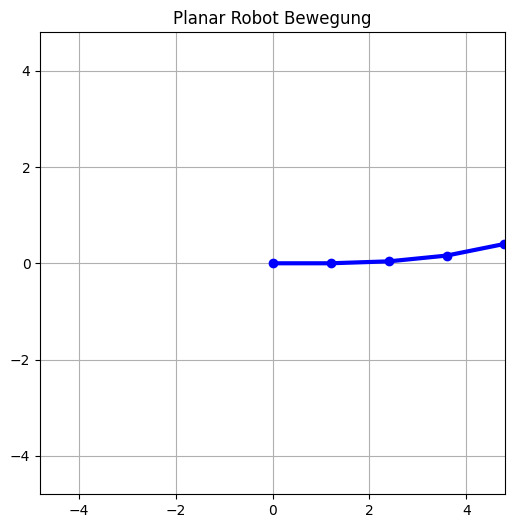

In [5]:
if path:
    configs = planner.get_path_coordinates(path)
    animate_path(robot, configs)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from utils.planarRobot import PlanarRobot, KinChainCollisionChecker
from environment import get_all_scenes
from matplotlib.animation import FuncAnimation


In [7]:
# --- Konfiguration für 2 DOF Beispiel ---
DOF = 2
link_lengths = [1.5] * DOF
robot = PlanarRobot(n_joints=DOF, link_lengths=link_lengths)

# Beispielszene laden
scenes = get_all_scenes()
scene_name, (scene, limits, (start_pos, goal_pos)) = scenes[0]  # erste Szene

# Kollisionstestobjekt erzeugen
collision_checker = KinChainCollisionChecker(robot, scene, fk_resolution=0.05)

In [15]:
# PRM-Planer instanziieren
planner = BasicPRM(collision_checker, limits=[[-np.pi]*DOF, [np.pi]*DOF])

# Start- und Zielkonfigurationen (in Joint-Space)
start = [[0.0, 0.1]]
goal = [[np.pi/2, np.pi/2.5]]

config = {"numNodes": 400, "radius": 1.5}

# Planung durchführen
path = planner.plan_path(start, goal, config)
print("Pfad gefunden!" if path else "Kein Pfad gefunden.")
print(f"Anzahl der Knoten im PRM: {planner.graph.number_of_nodes()}")
print(f"Gefundene Pfadlänge: {len(path)}" if path else "Kein Pfad gefunden.")
print(f"Knoten der Lösung: {path}" if path else "Keine Knoten in der Lösung.")


Pfad gefunden!
Anzahl der Knoten im PRM: 402
Gefundene Pfadlänge: 12
Knoten der Lösung: ['start', 3, 11, 14, 10, 23, 40, 5, 6, 39, 20, 'goal']


In [16]:
# Visualisierung

def animate_path(robot, path_configs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Roboterarbeitsraum vorbereiten
    ax1.set_xlim(-sum(robot.link_lengths), sum(robot.link_lengths))
    ax1.set_ylim(-sum(robot.link_lengths), sum(robot.link_lengths))
    ax1.set_aspect("equal")
    ax1.grid(True)
    ax1.set_title(f"Planar Roboter Bewegung ({DOF} DOF)")

    # Hindernisse darstellen
    for obs in scene.values():
        if hasattr(obs, "exterior"):
            xs, ys = obs.exterior.xy
            ax1.fill(xs, ys, color='red', alpha=0.4)

    line1, = ax1.plot([], [], 'o-', lw=3, color='green')

    # Konfigurationsraum vorbereiten
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_ylim(-np.pi, np.pi)
    ax2.set_aspect("auto")
    ax2.grid(True)
    ax2.set_title("Konfigurationsraum")
    line2, = ax2.plot([], [], 'o-', color='blue')

    def update(i):
        pos = robot.forward_kinematics(path_configs[i])
        xs, ys = zip(*pos)
        line1.set_data(xs, ys)

        # Zeige aktuelle Konfiguration (Joint-Achsen) im C-Space
        q = path_configs[i]
        line2.set_data([q[0]], [q[1]])
        return line1, line2

    ani = FuncAnimation(fig, update, frames=len(path_configs), interval=100, blit=True)
    plt.tight_layout()
    plt.show()

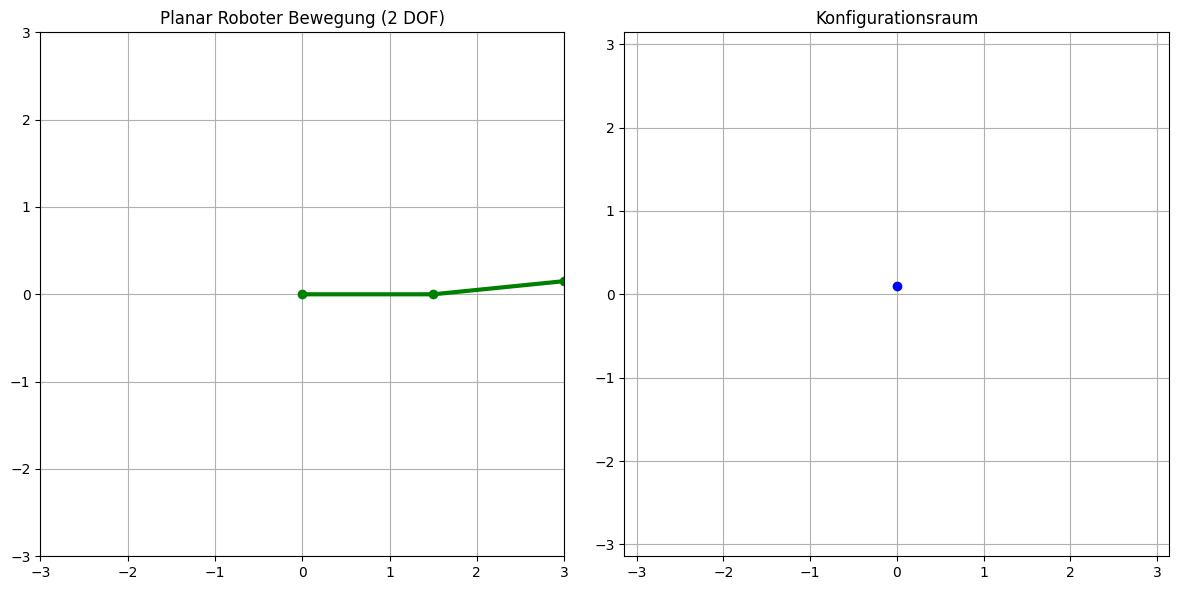

In [17]:
if path:
    configs = planner.get_path_coordinates(path)
    animate_path(robot, configs)
